In [1]:
#all the imports used in the program

import pandas as pd 
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from keras.optimizers import Adam
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import sklearn.metrics as skm

Using TensorFlow backend.


In [2]:
#Grab data from a database

def getData(Server, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                          'SERVER='+Server+';' 
                          'DATABASE='+Database+';' 
                          'Trusted_Connection=yes')
    
    #return the data from the given Query and SQL connection,
    #here i hard coded the index so all queries must select examCode
    #for other instances just simply change or remove depending on use
    return pd.read_sql(query, sql_conn)

In [3]:
#establish my server and corresponding database to pull data from
server ='GESTALT-BT41Q'
database = 'MClinical'

#this query grabs sectionValues with their corresponding examCode and description
#does not select examCodes if there is less than 100 section values for the corresponding examCode
#Stores the result in a pandas DataFrame object called data
query = "SELECT CPTCODEKEY.CPT88304, CPTCODEKEY.CPT88305, CPTCODEKEY.CPT88307, CPTCODEKEY.CPT88309, CPTCODEKEY.CPT88331, CPTCODEKEY.CPT88341, CPTCODEKEY.CPT88342, CPTCODEKEY.CPT88112, CPTCODEKEY.CPT88141, CPTCODEKEY.CPT88175, description, ResultSection.sectionValue FROM [MClinical].[dbo].[Result] LEFT JOIN ResultSection ON Result.resultKey = ResultSection.resultKey left join mapResultRequestedProcedure ON Result.resultKey = mapResultRequestedProcedure.resultKey  left join RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey left join FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey left join PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey left join ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey left join Patient on FillerOrder.patientKey = Patient.patientKey left join cptcodekey on patient.patientkey = cptcodekey.patient_key WHERE sectionValue <> ' ' and (ResultSection.sectionValue <>' No diagnosis; performed technical only ') and ResultSection.sectionCategory like '%gross%' and examCode not like '%:%' and description is not null and Patient.patientKey in ( select patient_key from cptcodekey ) order by patient.patientkey"



original = getData(server,database,query)
data = original.copy()


In [4]:
for i in data.sectionValue.values:
    if(type(i) == float):
        print(i)

In [5]:
#removes words that have at one colon somewhere in the middle of two words
#and words that have two colons separated by three words. 

def removeColon(df):
    
    #Word array of words that i will later remove
    bagOfWords = []
    
    #a array of every word in the sectionValue on the given dataframe df
    wordList = df.sectionValue.str.split(expand=True).stack()
    
    for word in wordList:
        colonWord = re.search(r"\w+:\w+:\w+", word)
        if colonWord is None:
            colonWord = re.search(r"\w+:\w+", word)
        if colonWord is not None:
            if colonWord.group() not in bagOfWords:
                bagOfWords.append(colonWord.group())
    
    #return the updated dataframe sectionValue, only keeping words that are not contained in bagOfWords            
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (bagOfWords)]))

This method is more useful than it looks.

You pass in a pandas DataFrame and tweak it.

First, i create a empty list called bagOfWords

The next line seemes confusing but bassically what I am doing here is taking every word from the sectionValue column and creating a list in which each row only contains one word. This helps with the iterative process. I store the result of this into WordList(approx 1.4 million words)

Next, i iterate through every word in the wordList in a for loop.

let me explain how the search process works and what words i am looking to add to my bagOfWords
1. How does the search processWork?
    1. I use Regex(regular expression) to do my searching for me which is on a character by character basis
2. What kind of words am i looking for?
    1. \w+:\w+ and \w+:\w+:\w+
        1. \w searches for any character in the form [a-zA-Z0-9]
        2. \+ searches for the previous search condition until the end of the word. 
        3. : specifies that i want a colon 
        4. putting it all together 
            1. \w+:\w+ searches for a character in the form [a-zA-Z0-9] for any amount of characters in that form until it hits a colon : in which then it does the same \w+ until the end of the word.
            2. \w+:\w+:\w+ is the same as above just has two colons i hope you get the picture..
            
     
Since i am searching for two different types of words i need to search two different times for every word in wordList.

I search the word to see if it matches the pattern of having three words separated by 2 colons, this returns a match object which i store in colonWord.

if the word isnt found in the search it returns None, so i check if colonWord is None. If it is i search for the different type of word and store that searches result into colonWord.

After that process is done i finally check to see if either of my searches came back true(not None)

If they do i use colonWord.group() function to grab just the string(word) that it found.

Then Check the bagOfWords to see if the word i found is already in it. 

If the word is already in it I move onto the next word in the wordList.

if it is not, i simply  add it and move to the next word as well. 

Finally once i have scanned all words and created my bagOfWords that is a unique list i remove those words from the sectionValue column of the Data. 

what the last line in the funtion is doing is recreating my column sectionValue, but only keeping words that are NOT in bagOfWords.

Once that is done i return the new column of sectionValue. 

In [6]:
#here i wanted to remove punctuation from the column sectionValue in my pandas dataFrame
#i replace every character that matches with one of the following below with nothing.

def removePunctuation(df1):
    df1['sectionValue'] = df1['sectionValue'].str.replace(',', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('.', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('?', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('+', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('-', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('=', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('_', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(')', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('(', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('*', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('&', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('^', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('%', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('$', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('#', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('@', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('!', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('>', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('<', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('[', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(']', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('{', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('}', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('|', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(':', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(';', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\'', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\"', '')
    return df1
    

In [7]:
def removeStopWords(df):
    
    #stopWords are words that have relatively no meaning to any actual data
    #we dont want that here so lets remove them
    stop = stopwords.words('english')
    
    # add custom stopWords 
    stop = addStopWords(stop)
    
    # add this if you want to remove words that are smaller than size two
    # change the size to whatever you like 
    
    #df['sectionValue'] = df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    
    #returning the new sectionValue to the Datafram with words that are not in the StopWords
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [8]:
#adding my own custom stopWords
#super simple to add as you can see 
#modify as needed!

def addStopWords(stop):
    stop.append('-')
    stop.append('a')
    stop.append('b')
    stop.append('c')
    stop.append('d')
    stop.append('e')
    stop.append('f')
    stop.append('g')
    stop.append('h')
    stop.append('i')
    stop.append('j')
    stop.append('k')
    stop.append('l')
    stop.append('m')
    stop.append('n')
    stop.append('o')
    stop.append('p')
    stop.append('q')
    stop.append('r')
    stop.append('s')
    stop.append('t')
    stop.append('u')
    stop.append('v')
    stop.append('w')
    stop.append('x')
    stop.append('y')
    stop.append('z')
    stop.append('no')
    stop.append('see')
    stop.append('two')
    stop.append('0')
    stop.append('1')
    stop.append('2')
    stop.append('3')
    stop.append('4')
    stop.append('5')
    stop.append('6')
    stop.append('7')
    stop.append('8')
    stop.append('9')
    return stop

In [9]:
#clean_text transforms words like tomatoes, tomato, tomatos, all to tomato. this is very helpful.

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\csorensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
#concatinate the sectionValue and description feild
def concatExamDesc(df):
    return  df['description'] + ' ' + df['sectionValue']

In [11]:
def clean(df):
    #change the case of all the words to lower case so there is no case sensitivity.
    df['sectionValue'] = df['sectionValue'].str.lower()

    #call the removeColon function to remove words with a colon or mulitple colons in the middle of the word
    df['sectionValue'] = removeColon(df)

    #call the removePuncuation code, notice how i did this after the removeColon function.
    #it is important that we call this after the removeColon Function because this would remove colons
    #from words we want to remove, and then the remove colon function would never find anything because there is no colons. 
    df = removePunctuation(df)

    #call the removeStopWords function to remove words that have no meaning.
    df['sectionValue'] = removeStopWords(df)

    #call the clean_text to place words of simularity with the base word (ex: biopsies -> biopsy)
    df['sectionValue'] = df.sectionValue.apply(lambda x: clean_text(x))

    #add the description to the sectionValue
    df['sectionValue'] = concatExamDesc(df)
    return df['sectionValue']

In [12]:
data['sectionValue'] = clean(data)
data.sectionValue.apply(lambda x: len(x.split(" "))).mean()

99.01414799916776

In [13]:
def convert_text(df, maxlen, max_words):
    #split df into two series
    #texts being the sectionValue
    #labels being the cooresponding examCode
    texts = df.sectionValue
    
    #convert the series into numpy arrays
    texts = texts.values
    
    #create a tokenizer based on the max_words
    #fit the tokenizer to our specific texts
    #change our texts to a vetorized integer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    #pad sequences ensures that all our vectors are of the same length
    x = pad_sequences(sequences, maxlen=maxlen)
    
    d = defaultdict(LabelEncoder)
    
    fit = df[['CPT88304', 'CPT88305', 'CPT88307',
            'CPT88309', 'CPT88331', 'CPT88341', 
            'CPT88342', 'CPT88112', 'CPT88141', 
            'CPT88175']].apply(lambda y: d[y.name].fit_transform(y))   
    labels = fit.values

    print('Shape of data tensor:', x.shape)
    print('Shape of label tensor:', labels.shape)

    #we need to randomize the indexs of our data because we had 
    #entered it all in ordely fashion. we dont want that. 
    #our model wouldnt learn correctly if it was ordered by examCode..
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    labels = labels[indices]
    
    #return x, labels, and the last 7000 of x and labels for testing
    return x[:13000], labels[:13000], x[-1419:], labels[-1419:]

In [14]:
#define maxlen as the maximum words to take from each sectionValue
#define max_words as the total number of unique words to tokenize

maxlen = 150
max_words = 20000

#create data that can be ran through our model
x_train, y_train, x_test, y_test = convert_text(data, maxlen, max_words)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Found 16999 unique tokens.
Shape of data tensor: (14419, 150)
Shape of label tensor: (14419, 10)
(13000, 150)
(13000, 10)
(1419, 150)
(1419, 10)


In [105]:
#create a machine learning model with the following
def create_model(max_words,maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length to what we have already
    #configured for our vectorized forms of our text
    model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
    
    #model.add(Bidirectional(LSTM(64)))
    
    model.add(Dropout(0.15))
    model.add(Conv1D(maxlen, 3, padding='valid', activation='relu', strides=1))
    #model.add(Dropout(0.5))
    #model.add(Conv1D(maxlen, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    # create a dense output layer with the units = len(labels_dict)
    model.add(Dense(10, activation='sigmoid'))
    
    #print the summary
    model.summary()
    
    return model

In [133]:
#create the model
model = create_model(max_words, maxlen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 150, 50)           1000000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 150, 50)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 148, 150)          22650     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 150)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1510      
Total params: 1,024,160
Trainable params: 1,024,160
Non-trainable params: 0
_________________________________________________________________


In [134]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> rmsprop (standard)
    #loss -> sparse categorical crossentropy (because we have a large multiclassifcation probelm)
    #meteric -> accuracy
    model.compile(optimizer=Adam(lr=0.00009),
                  loss='binary_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model 
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0.2)
    return history

In [130]:
#train the model
history = train_model(model, x_train, y_train, 75, 500, max_words, maxlen)

Train on 10400 samples, validate on 2600 samples
Epoch 1/50
10400/10400 [==============================] - 17s 2ms/step - loss: 0.6561 - acc: 0.7711 - val_loss: 0.6142 - val_acc: 0.8956
Epoch 2/50
10400/10400 [==============================] - 14s 1ms/step - loss: 0.5686 - acc: 0.8948 - val_loss: 0.5181 - val_acc: 0.8956
Epoch 3/50
10400/10400 [==============================] - 15s 1ms/step - loss: 0.4650 - acc: 0.8948 - val_loss: 0.4135 - val_acc: 0.8956
Epoch 4/50
10400/10400 [==============================] - 16s 2ms/step - loss: 0.3709 - acc: 0.8948 - val_loss: 0.3371 - val_acc: 0.8956
Epoch 5/50
10400/10400 [==============================] - 15s 1ms/step - loss: 0.3172 - acc: 0.8949 - val_loss: 0.3029 - val_acc: 0.8958
Epoch 6/50
10400/10400 [==============================] - 15s 1ms/step - loss: 0.2947 - acc: 0.8951 - val_loss: 0.2871 - val_acc: 0.8953
Epoch 7/50
10400/10400 [==============================] - 16s 2ms/step - loss: 0.2823 - acc: 0.8975 - val_loss: 0.2766 - val_acc:

In [131]:
history1 = train_model(model, x_train, y_train, 10, 500, max_words, maxlen)

Train on 10400 samples, validate on 2600 samples
Epoch 1/10
10400/10400 [==============================] - 20s 2ms/step - loss: 0.1040 - acc: 0.9644 - val_loss: 0.1431 - val_acc: 0.9507
Epoch 2/10
10400/10400 [==============================] - 15s 1ms/step - loss: 0.1018 - acc: 0.9652 - val_loss: 0.1431 - val_acc: 0.9503
Epoch 3/10
10400/10400 [==============================] - 16s 1ms/step - loss: 0.1000 - acc: 0.9658 - val_loss: 0.1432 - val_acc: 0.9507
Epoch 4/10
10400/10400 [==============================] - 16s 2ms/step - loss: 0.0982 - acc: 0.9660 - val_loss: 0.1433 - val_acc: 0.9503
Epoch 5/10
10400/10400 [==============================] - 15s 1ms/step - loss: 0.0969 - acc: 0.9671 - val_loss: 0.1433 - val_acc: 0.9502
Epoch 6/10
10400/10400 [==============================] - 14s 1ms/step - loss: 0.0948 - acc: 0.9676 - val_loss: 0.1434 - val_acc: 0.9506
Epoch 7/10
10400/10400 [==============================] - 12s 1ms/step - loss: 0.0934 - acc: 0.9679 - val_loss: 0.1437 - val_acc:

KeyboardInterrupt: 

In [84]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    #display the max values we attained
    print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
    print('Training Accuracy: ', acc[np.argmax(acc)] * 100)

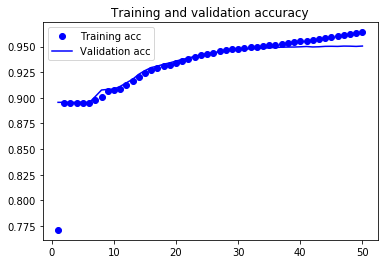

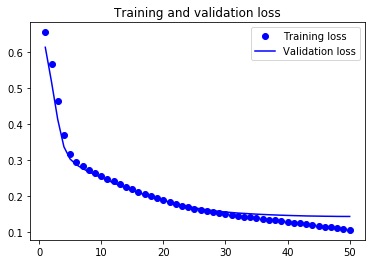

Validation Accuracy:  95.05386581787695
Training Accuracy:  96.40097939051114


In [132]:
training_report(history)

In [65]:
#test the model on our set aside testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a list of all the cpt codes 
    #with percents in each category at how confident the model is for 
    #each cptCode. 
    
    #since we used a binary classifier
    #anything above .5 will  be considered true
    #and anything below .5 will be considered false
    preds = model.predict(x_test)
    
    #for ever row in the prediction list
    #change every column value for the specific row
    #where the percent is above or equal to .5 to 1 
    #and below .5 to 0
    preds[preds>=0.5] = 1
    preds[preds<0.5] = 0
    
    #convert the list to a numpy array
    return np.asarray(preds)

In [86]:
#test the model against our test data and store the predictions in y_pred
y_pred = test_model(model, x_test)

In [67]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    matrix = skm.multilabel_confusion_matrix(y_test, y_pred)
    
    #create a label_dict
    temp = ['88304', '88305', '88307',
                '88309', '88331', '88341', 
                '88342', '88112', '88141', 
                '88175']
    label_dict = np.asarray(temp)


    #print the confusion matrix 
    #rows are the models predictions
    #columns is the test

    #since the matrix is of shape 10 x 2 x 2 
    #we will go through each 2 x 2 matrix to display
    #each cpt codes individual confusion matrix

    x = 0
    for i in matrix:
        #convert matrix to a pandas df to convert
        #index and columns to cpt codes
        print(x)
        dfmatrix = pd.DataFrame(i, columns=[0,label_dict[x]], index=[0,label_dict[x]])
        print(dfmatrix, '\n\n')
        x = x+1

    

In [68]:
#create the classification report
def test_classification_report(y_pred,y_test):
    #cr from index values
    print(skm.classification_report(y_test, y_pred))

In [87]:
test_confusion_matrix(y_pred,y_test)

0
          0  88304
0      1211      9
88304    58    141 


1
         0  88305
0      221     95
88305   74   1029 


2
          0  88307
0      1031     57
88307    82    249 


3
          0  88309
0      1346      7
88309    39     27 


4
          0  88331
0      1343      1
88331    16     59 


5
          0  88341
0      1277     24
88341    72     46 


6
          0  88342
0      1078     35
88342    86    220 


7
          0  88112
0      1376      0
88112    43      0 


8
          0  88141
0      1319     29
88141    47     24 


9
          0  88175
0      1321     29
88175    44     25 




In [88]:
#display the classification report on the predictions
test_classification_report(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       199
           1       0.92      0.93      0.92      1103
           2       0.81      0.75      0.78       331
           3       0.79      0.41      0.54        66
           4       0.98      0.79      0.87        75
           5       0.66      0.39      0.49       118
           6       0.86      0.72      0.78       306
           7       0.00      0.00      0.00        43
           8       0.45      0.34      0.39        71
           9       0.46      0.36      0.41        69

   micro avg       0.86      0.76      0.81      2381
   macro avg       0.69      0.54      0.60      2381
weighted avg       0.84      0.76      0.80      2381
 samples avg       0.91      0.85      0.85      2381



In [89]:
1 -skm.hamming_loss(y_test,y_pred)

0.9403100775193799